In [ ]:
!pip install openai pandas scikit-learn matplotlib seaborn tqdm

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 26.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 360.7/360.7 kB 32.0 MB/s eta 0:00:00


In [ ]:
import time
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
from sklearn.metrics import accuracy_score, precision_recall_fscore_support
from openai import OpenAI

client = OpenAI(api_key="YOUR_OPENAI_API_KEY")

In [ ]:
df = pd.read_csv("/content/movie_genres.csv")
df

,genre,description
0,thriller,brother sister past incestuous relationship cu...
1,horror,four high school students embark terrifying jo...
2,thriller,photographer sailing wife sister nympho maniac...
3,action,dong woo released prison short time following ...
4,thriller,marie insecure housewife whose husband joe aff...
...,...,...
5105,thriller,dorien young photographer overwhelming persona...
5106,horror,director russell head secret government agency...
5107,horror,living town near munich four friends work wait...
5108,horror,patient described extremely dangerous escaped ...


In [ ]:
df['genre'].unique()

array(['thriller', 'horror', 'action'], dtype=object)

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5110 entries, 0 to 5109
Data columns (total 2 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   genre        5110 non-null   object
 1   description  5110 non-null   object
dtypes: object(2)
memory usage: 80.0+ KB


In [ ]:
def normalize_genre(output):
    """
    Convert LLM output to one of the expected labels exactly:
    'action', 'thriller', or 'horror'.
    """
    output = output.lower().strip()
    if output.startswith("action"):
        return "action"
    elif output.startswith("thriller"):
        return "thriller"
    elif output.startswith("horror"):
        return "horror"
    else:
        return "unknown"

# Zero-Shot Prompt

In [ ]:
def zero_shot(text):
    prompt = f"""
    Classify the following movie description into its genre.
    Respond with only one of: action, thriller, horror.

    Description: {text}
    Genre:
    """
    return call_llm(prompt)

# Few-Shot Prompt

In [ ]:
def few_shot(text):
    prompt = f"""
    Example 1:
    Description: A family must survive a haunted house during a storm.
    Genre: horror

    Example 2:
    Description: A retired spy is pulled back into a dangerous mission.
    Genre: action

    Example 3:
    Description: A detective solves a series of murders in a small town.
    Genre: thriller

    Now classify the following. Respond with only one label: action, thriller, horror.

    Description: {text}
    Genre:
    """
    return call_llm(prompt)

# Chain-of-Thought Prompt

In [ ]:
def cot_prompt(text):
    prompt = f"""
    Classify this movie description step by step:

    Description: {text}

    First, analyze the plot, tone, and theme. Then give the final genre.
    Respond with only one label: action, thriller, horror.
    Final Answer:
    """
    return call_llm(prompt)


# Self-Consistency

In [ ]:
def self_consistency(text, runs=3):
    outputs = []
    latencies = []
    for _ in range(runs):
        output, latency = cot_prompt(text)
        outputs.append(normalize_genre(output))
        latencies.append(latency)
    final_output = max(set(outputs), key=outputs.count)
    return final_output, np.mean(latencies)


# ReAct Prompt

In [ ]:
def react_prompt(text):
    prompt = f"""
    You are an expert movie analyst.

    Thought: Analyze key plot elements and emotional tone.
    Action: Decide which genre fits best (action, thriller, horror).
    Observation: Take note of suspense, violence, or supernatural elements.

    Description: {text}

    Respond with only one label: action, thriller, horror.
    Final Answer:
    """
    return call_llm(prompt)


# Knowledge-Augmented Prompt

In [ ]:
def knowledge_prompt(text):
    prompt = f"""
    Genre Guidelines:
    - Action: Fast-paced, conflict, stunts, battles
    - Thriller: Suspense, crime, tension, mystery
    - Horror: Scary, supernatural, gore, fear

    Description: {text}
    Respond with only one label: action, thriller, horror.
    Genre:
    """
    return call_llm(prompt)


In [ ]:
def call_llm(prompt, max_retries=5):
    for i in range(max_retries):
        try:
            start = time.time()
            response = client.chat.completions.create(
                model="gpt-3.5-turbo",
                messages=[{"role": "user", "content": prompt}],
                temperature=0.3
            )
            latency = time.time() - start
            output = response.choices[0].message.content.strip()
            return output, latency
        except RateLimitError:
            wait_time = 2 ** i
            print(f"Rate limit hit. Waiting {wait_time}s before retry...")
            time.sleep(wait_time)
    raise Exception("Max retries exceeded for prompt.")

In [ ]:
import os
os.environ["OPENAI_API_KEY"] ="paste your key here"

In [ ]:
from openai import OpenAI
client = OpenAI(api_key=os.getenv("OPENAI_API_KEY"))

In [ ]:
techniques = {
    "Zero-Shot": zero_shot,
    "Few-Shot": few_shot,
    "Chain-of-Thought": cot_prompt,
    "Self-Consistency": self_consistency,
    "ReAct": react_prompt,
    "Knowledge": knowledge_prompt
}

results = []

subset_df = df.sample(1000, random_state=42)

for name, func in techniques.items():
    print(f"\nRunning technique: {name}")
    predictions = []
    latencies = []

    for text in tqdm(subset_df["description"]):
        output, latency = func(text)
        output = normalize_genre(output)
        predictions.append(output)
        latencies.append(latency)

    acc = accuracy_score(subset_df["genre"], predictions)
    precision, recall, f1, _ = precision_recall_fscore_support(
        subset_df["genre"], predictions, average="weighted", zero_division=0
    )

    results.append({
        "Technique": name,
        "Precision": precision,
        "Recall": recall,
        "F1": f1,
        "Avg Latency": np.mean(latencies)
    })

results_df = pd.DataFrame(results)


Running technique: Zero-Shot


100%|██████████| 1000/1000 [06:56<00:00,  2.40it/s]



Running technique: Few-Shot


100%|██████████| 1000/1000 [06:48<00:00,  2.45it/s]



Running technique: Chain-of-Thought


100%|██████████| 1000/1000 [07:13<00:00,  2.31it/s]



Running technique: Self-Consistency


100%|██████████| 1000/1000 [20:39<00:00,  1.24s/it]



Running technique: ReAct


100%|██████████| 1000/1000 [06:51<00:00,  2.43it/s]



Running technique: Knowledge


100%|██████████| 1000/1000 [06:56<00:00,  2.40it/s]


In [ ]:
results_df

,Technique,Precision,Recall,F1,Avg Latency
0,Zero-Shot,0.809099,0.751,0.758261,0.415562
1,Few-Shot,0.796091,0.749,0.754249,0.407450
2,Chain-of-Thought,0.817539,0.781,0.790598,0.431908
3,Self-Consistency,0.820790,0.779,0.790450,0.412778
4,ReAct,0.802360,0.759,0.765867,0.410277
5,Knowledge,0.795395,0.734,0.738690,0.415156


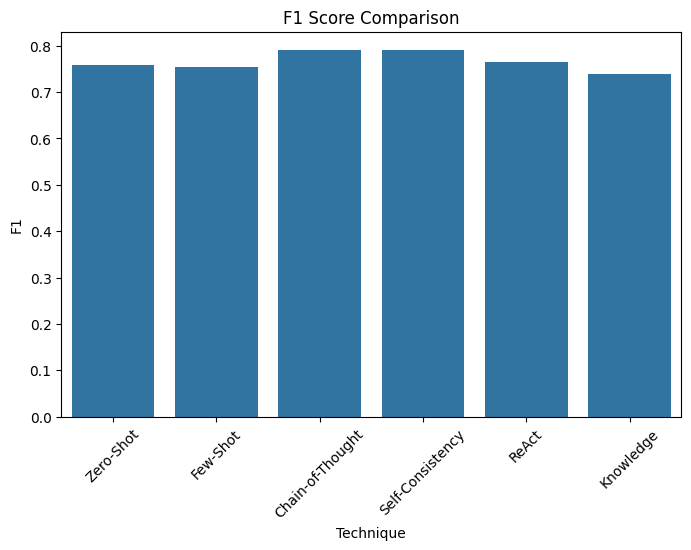

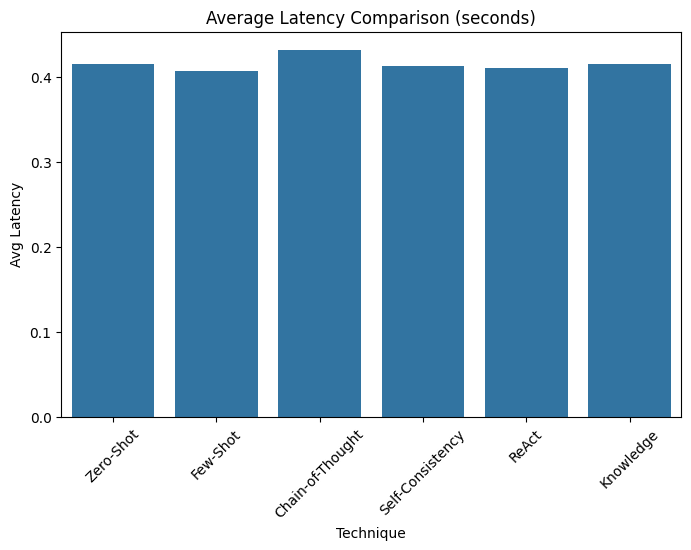

In [ ]:
plt.figure(figsize=(8,5))
sns.barplot(data=results_df, x="Technique", y="F1")
plt.title("F1 Score Comparison")
plt.xticks(rotation=45)
plt.show()

plt.figure(figsize=(8,5))
sns.barplot(data=results_df, x="Technique", y="Avg Latency")
plt.title("Average Latency Comparison (seconds)")
plt.xticks(rotation=45)
plt.show()
